[View in Colaboratory](https://colab.research.google.com/github/AdityaGupta-IITD/Super_Convergence_Neural_Nets/blob/master/Discriminative_Learning_CLR.ipynb)

In [0]:
!pip install tqdm
!pip install Cython

In [0]:
!pip install git+https://github.com/taehoonlee/tensornets.git
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

!mkdir .kaggle
!cp kaggle.json ~/.kaggle/
!rm kaggle.json

In [0]:
!mkdir Dataset
!mkdir Dataset/Train_data
!mkdir Dataset/Validation_data
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content/Dataset

import zipfile
import os

with zipfile.ZipFile('Dataset/train.zip') as myzip:
    myzip.extractall('Dataset/')
    os.remove('Dataset/train.zip')
    
with zipfile.ZipFile('Dataset/test.zip') as myzip:
    myzip.extractall('Dataset/')
    os.remove('Dataset/test.zip')

In [0]:
import os
from os.path import isfile, isdir
from os import listdir, rename

from tqdm import tqdm
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensornets as nets

In [0]:
img_height = 256; img_width = 256; num_classes = 2; split_factor = 0.9; batch_size = 50; 
data_loc = '/content/Dataset/train/'; train_dest = '/content/Dataset/Train_data/'; valid_dest = '/content/Dataset/Validation_data/'

In [0]:
def create_training_and_validation_dataset(data_loc, train_data_dest, valid_data_dest, split_factor, num_classes):
  
  file_name = [s for s in listdir(data_loc)] 

  for ind in range(len(file_name)):
    if(ind < int(split_factor*len(file_name))):
      os.rename(data_loc + file_name[ind], train_data_dest + file_name[ind])
    else:
      os.rename(data_loc + file_name[ind], valid_data_dest + file_name[ind])

  train_data_path = [train_data_dest + s for s in os.listdir(train_data_dest)]
  valid_data_path = [valid_data_dest + s for s in os.listdir(valid_data_dest)]

  train_labels = np.zeros((len(train_data_path), num_classes))
  valid_labels = np.zeros((len(valid_data_path), num_classes))

  for ind in range(len(train_data_path)):
    if("cat" in train_data_path[ind]):train_labels[ind][0] = 1
    elif("dog" in train_data_path[ind]):train_labels[ind][1] = 1

  for ind in range(len(valid_data_path)):
    if("cat" in valid_data_path[ind]):valid_labels[ind][0] = 1
    elif("dog" in valid_data_path[ind]):valid_labels[ind][1] = 1
      
  return train_data_path, valid_data_path, train_labels, valid_labels 

train_data_path, valid_data_path, train_labels, valid_labels = create_training_and_validation_dataset(data_loc, train_dest, valid_dest, 
                                                                                                      split_factor, num_classes = 2)

In [0]:
def preprocess_fn(image, label, flip_left_right = True, brightness = True, brightness_range = 0.2, contrast = True, lower_con = 0.75, 
                  upper_con = 1.5, saturation = True, lower_sat = 0.75, upper_sat = 1.5, crop = True, crop_size = 225):
  
  if flip_left_right:
    image = tf.image.random_flip_left_right(image)
  if brightness:
    image = tf.image.random_brightness(image, max_delta = brightness_range)
  if contrast:
    image = tf.image.random_contrast(image, lower = lower_con, upper = upper_con)
  if saturation:
    image = tf.image.random_saturation(image, lower = lower_sat, upper = upper_sat)
  if crop:
    image = tf.random_crop(image, size = [crop_size, crop_size, 3])
    image = tf.image.resize_images(image, size = [img_height, img_width])
    
  image = tf.clip_by_value(image, 0.0, 1.0)
  
  return image, label

def parse_fn(filename, label):
  
  image = tf.divide(tf.image.resize_images(tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.read_file(filename)), tf.float32), [img_height, img_width]), 255.0)
  
  return image, label

In [0]:
def create_training_validation_iterator(sess, train_data_path, train_labels, valid_data_path, valid_labels, num_epochs, augmentation = False):

  train_dataset = tf.data.Dataset.from_tensor_slices((train_data_path, train_labels))
  train_dataset = train_dataset.shuffle(buffer_size = len(train_data_path), reshuffle_each_iteration = True).repeat(num_epochs)
  train_dataset = train_dataset.map(lambda x, y: parse_fn(x, y), num_parallel_calls = 4)
  
  if augmentation == True:
    train_dataset = train_dataset.map(lambda x, y: preprocess_fn(x, y), num_parallel_calls = 4)
  
  train_dataset = train_dataset.batch(batch_size)
  train_dataset = train_dataset.prefetch(5)

  valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data_path, valid_labels))
  valid_dataset = valid_dataset.shuffle(buffer_size = len(valid_data_path), reshuffle_each_iteration = False).repeat(num_epochs)
  valid_dataset = valid_dataset.map(lambda x, y: parse_fn(x, y), num_parallel_calls = 4)
  valid_dataset = valid_dataset.batch(batch_size)
  valid_dataset = valid_dataset.prefetch(5)
  
  handle = tf.placeholder(tf.string, shape = [])
  iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)
  next_element = iterator.get_next()
  
  training_iterator = train_dataset.make_initializable_iterator()
  validation_iterator = valid_dataset.make_initializable_iterator()
  training_handle = sess.run(training_iterator.string_handle())
  validation_handle = sess.run(validation_iterator.string_handle())

  return training_iterator, validation_iterator, training_handle, validation_handle, handle, next_element

In [0]:
def initialize_model():

  x = tf.placeholder(tf.float32, shape = [None, img_height, img_width, 3], name = 'input_images')
  y = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'true_labels')
  global_step = tf.Variable(0, name = "global_step", trainable = False)

  logits = nets.ResNeXt50(x, is_training = True, classes = num_classes)
  loss = tf.losses.softmax_cross_entropy(y, logits)

  correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
  
  return x, y, logits, loss, correct_pred, accuracy, global_step

In [0]:
import numpy

def smooth(x, window_len = 11, window = 'flat'):

    if window_len<3:
        return x     
      
    s = numpy.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    
    if window == 'flat':
        w = numpy.ones(window_len, 'd')
    else:
        w = eval('numpy.'+window+'(window_len)')
    
    y = numpy.convolve(w/w.sum(), s, mode = 'valid')
    
    return y

In [0]:
init_step_size = (len(train_data_path))//(2*batch_size);

def lr_scheduler(max_lr, opt_lr, curr_iter, scheduler, step_size):
  
  if scheduler == 'CLR':
    cycle = np.ceil((1 + curr_iter)/(2*step_size))
    half_cycle_point = np.abs(curr_iter/step_size - 2*cycle + 1)
    lr = opt_lr + (max_lr - opt_lr)*(1 - half_cycle_point)

  if scheduler == 'SGDR':
    T_curr = curr_iter / (init_step_size*2);
    T_i = step_size / init_step_size
    lr = 0.5*(max_lr)*(1 + np.cos((T_curr*np.pi)/(T_i)))

  return lr

In [0]:
def lr_finder(epochs = 2, min_lr = 1e-6, max_lr = 1e1, layers_to_train_from_last = 2):
  
  g_lr_finder = tf.Graph()
  
  with g_lr_finder.as_default():
    with tf.Session() as sess:
      
      x, y, logits, loss, correct_pred, accuracy, global_step = initialize_model()

      num_iters = (len(train_data_path)*epochs)//batch_size; train_loss_collection = []; valid_loss_collection = []; 
      learning_rate_collection = []; valid_acc_collection = [];
      lr = tf.placeholder(tf.float32, shape = (), name = 'learning_rate')
      
      training_iterator, validation_iterator, train_init_op, valid_init_op, handle, next_element = create_training_validation_iterator(sess, 
                                                        train_data_path, train_labels, valid_data_path, valid_labels, epochs, augmentation = False)
      
      var_list = tf.trainable_variables()[-1*layers_to_train_from_last:]
      train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss, var_list = var_list)

      sess.run([tf.global_variables_initializer()])
      sess.run(logits.pretrained())
      
      print('LR_Finder statrted...')
      const = np.float32(np.power(max_lr/min_lr, 1/num_iters))

      for ptr in range(num_iters):
        
        curr_lr = min_lr*np.power(const, ptr)
        
        sess.run(training_iterator.initializer)
        images, true_labels = sess.run(next_element, feed_dict = {handle: train_init_op})
        _, train_loss = sess.run([train_op, loss], feed_dict = {x: images, y: true_labels, lr: curr_lr})
        
        sess.run(validation_iterator.initializer)
        images, true_labels = sess.run(next_element, feed_dict = {handle: valid_init_op})
        valid_loss, valid_acc = sess.run([loss, accuracy], feed_dict = {x: images, y: true_labels})
        
        train_loss_collection.append(train_loss); valid_loss_collection.append(valid_loss); 
        valid_acc_collection.append(valid_acc); learning_rate_collection.append(curr_lr);

        if ptr % 200 == 0:
          print(f'Training/Validation loss after {ptr} iterations is: {train_loss}, {valid_loss}')

      train_loss_collection_smooth = smooth(train_loss_collection); valid_loss_collection_smooth = smooth(valid_loss_collection); 
      valid_acc_collection_smooth = smooth(valid_acc_collection);

      plt.figure(figsize = (12, 12))
      plt.subplot(2, 1, 1)
      plt.plot(np.arange(num_iters), learning_rate_collection, 'r')
      plt.subplot(2, 1, 2)
      plt.plot(np.log10(learning_rate_collection), train_loss_collection_smooth[:num_iters], 'b')
      plt.plot(np.log10(learning_rate_collection), valid_loss_collection_smooth[:num_iters], 'g')
      plt.plot(np.log10(learning_rate_collection), valid_acc_collection_smooth[:num_iters], 'k')
      plt.show()
      
    sess.close()
  
  return

LR_Finder statrted...
Training/Validation loss after 0 iterations is: 0.653832197189331, 0.6691741943359375 respectively
Training/Validation loss after 200 iterations is: 0.6376965045928955, 0.7275004386901855 respectively
Training/Validation loss after 400 iterations is: 0.4115159511566162, 0.40472668409347534 respectively
Training/Validation loss after 600 iterations is: 0.4141136109828949, 0.34304797649383545 respectively
Training/Validation loss after 800 iterations is: 0.37335678935050964, 0.3137352764606476 respectively


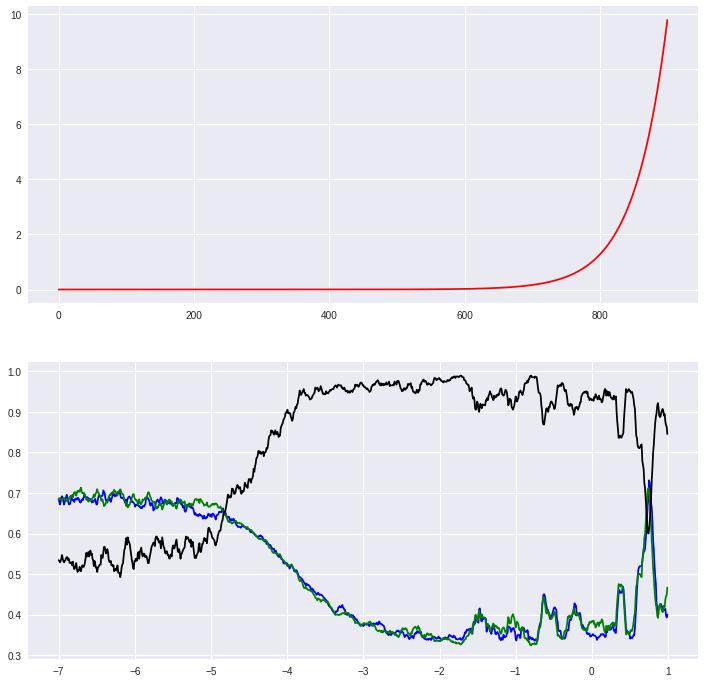

In [11]:
lr_finder(epochs = 2)

In [0]:
def training(learning_rate, step_size = 10, scheduler = 'None', num_cycles = 3, cycle_mult = 1, ckpt_path_restore = 'None', ckpt_path_save = 'None', 
             layers_to_train_from_last = 2, restore = False, augmentation = False):
  
  if not os.path.exists(ckpt_path_save):
    os.makedirs(ckpt_path_save)
    
  g_train = tf.Graph()
  with g_train.as_default():
    
    sess = tf.Session()
    x, y, logits, loss, correct_pred, accuracy, global_step = initialize_model()
    
    training_iterator, validation_iterator, train_init_op, valid_init_op, handle, next_element = create_training_validation_iterator(sess, 
                                                        train_data_path, train_labels, valid_data_path, valid_labels, 31, augmentation = False)
      
    num_iters_valid = len(valid_data_path)//batch_size; valid_loss_collection = []; valid_acc_collection = []; 
    train_loss_collection = []; train_acc_collection = []; 

    lr = tf.placeholder(tf.float32, shape = (3,), name = 'discriminative_learning_rate')
    var_list_1 = [v for v in tf.trainable_variables() if 'conv1' in v.name or 'conv2' in v.name or 'conv3' in v.name]
    var_list_2 = tf.trainable_variables()[len(var_list_1):-2]
    var_list_3 = tf.trainable_variables()[-2:]

    opt_1 = tf.train.AdamOptimizer(learning_rate = lr[0])
    opt_2 = tf.train.AdamOptimizer(learning_rate = lr[1])
    opt_3 = tf.train.AdamOptimizer(learning_rate = lr[2])

    grads = tf.gradients(loss, tf.trainable_variables())
    gradient_1 = grads[:len(var_list_1)]
    gradient_2 = grads[len(var_list_1):len(var_list_2)]
    gradient_3 = grads[-len(var_list_3):]

    train_op_1 = opt_1.apply_gradients(zip(gradient_1, var_list_1))
    train_op_2 = opt_2.apply_gradients(zip(gradient_2, var_list_2))
    train_op_3 = opt_3.apply_gradients(zip(gradient_3, var_list_3))
    train_op = tf.group(train_op_1, train_op_2, train_op_3)

    sess.run([tf.global_variables_initializer()])

    if restore == True:
      saver = tf.train.Saver(max_to_keep = 10)
      saver.restore(sess, ckpt_path_restore)
    else:
      sess.run(logits.pretrained())

    print('Training statrted...')
    max_learning_rate = learning_rate; min_learning_rate = [lr*0.25 for lr in learning_rate]; step_size = init_step_size; len_ = len(learning_rate)
    
    for cycle in range(num_cycles):  
      tot_train_loss = 0; tot_train_acc = 0;
      
      for ptr in range(step_size*2):
        if scheduler != 'None':
          learning_rate = list(map(lr_scheduler, max_learning_rate, min_learning_rate, [ptr]*len_, [scheduler]*len_, [step_size]*len_))
        
        sess.run(training_iterator.initializer)
        images, true_labels = sess.run(next_element, feed_dict = {handle: train_init_op})
        _, train_loss, train_acc = sess.run([train_op, loss, accuracy], feed_dict = {x: images, y: true_labels, lr: learning_rate})
        tot_train_loss += train_loss; tot_train_acc += train_acc;
        train_loss_collection.append(train_loss); train_acc_collection.append(train_acc);
        
      step_size = step_size*cycle_mult; 
      print(f'After {cycle + 1} cycles, Training loss: {tot_train_loss/(ptr+1)}, Training Accuracy: {tot_train_acc/(ptr+1)}')

      saver = tf.train.Saver(max_to_keep = 10)
      saver.save(sess, ckpt_path_save + "ckpt", global_step = global_step)
      sess.run(tf.assign(global_step, cycle + 1))
      tot_valid_loss = 0; tot_valid_acc = 0;
      
      for ptr in range(1, num_iters_valid + 1):
        
        sess.run(validation_iterator.initializer)
        images, true_labels = sess.run(next_element, feed_dict = {handle: valid_init_op})
        valid_loss, valid_acc = sess.run([loss, accuracy], feed_dict = {x: images, y: true_labels})
        tot_valid_loss += valid_loss; tot_valid_acc += valid_acc;
        valid_loss_collection.append(valid_loss); valid_acc_collection.append(valid_acc)
      
      print(f'After {cycle + 1} cycles, Validation loss: {tot_valid_loss/(ptr+1)}, Validation Accuracy: {tot_valid_acc/(ptr+1)}')

    plt.figure(figsize = (12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(valid_acc_collection)), valid_acc_collection, 'k')
    plt.plot(np.arange(len(valid_loss_collection)), valid_loss_collection, 'g')
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(train_loss_collection)), train_loss_collection, 'r')
    plt.plot(np.arange(len(train_acc_collection)), train_acc_collection, 'b')

    plt.show()
    
    sess.close()
    
  return

100442112/100440572 [==============================] - 5s 0us/step
Training statrted...
After 1 cycles, Training loss: 0.3743751354349984, Training Accuracy: 0.9655111145310932
After 1 cycles, Validation loss: 0.3319280153396083, Validation Accuracy: 0.9635294196652431
After 2 cycles, Training loss: 0.32672137373023563, Training Accuracy: 0.9920888917975955
After 2 cycles, Validation loss: 0.32106680496066226, Validation Accuracy: 0.9709803964577469
After 3 cycles, Training loss: 0.3217391427357992, Training Accuracy: 0.9947111139032576
After 3 cycles, Validation loss: 0.31925112593407723, Validation Accuracy: 0.9701960834802366


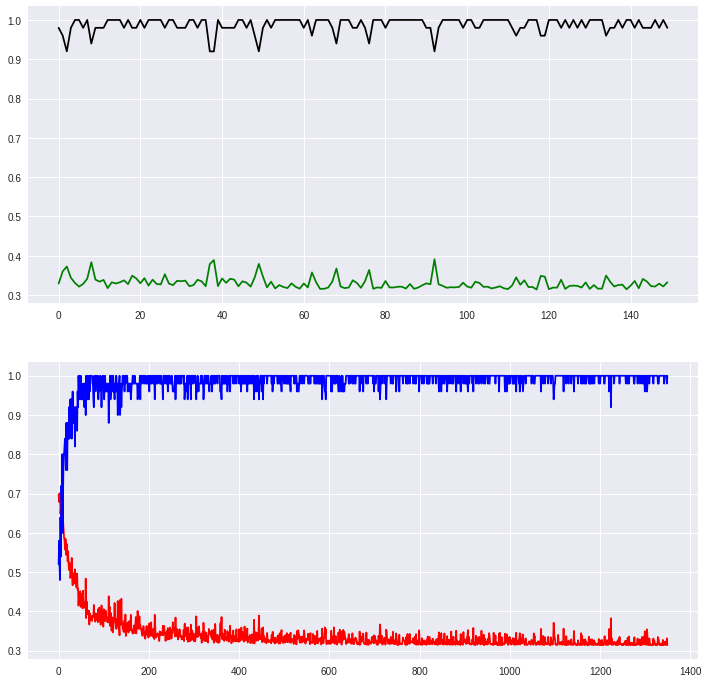

In [15]:
training(learning_rate = [2.5e-6, 2.5e-5, 2.5e-4], step_size = init_step_size, ckpt_path_save = './checkpoints/d_lr_c_1/', scheduler = 'None', 
         cycle_mult = 1)